# Chains in LangChain

## Outline

**1. LLMChain**
    - Most basic type of chain - combine a prompt with a LLM model<br>
<br>
**2. Sequential Chains**
    - Combine multiple chains where output of one chain is input of next chain
    
  2.1. SimpleSequentialChain: Single input/output<br>
  2.2. SequentialChain: Multiple inputs/outputs
<br>  
**3. Router Chain**


In [ ]:
# Load relevant libraries

import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [6]:
import pandas as pd
df = pd.read_csv('Data.csv')

In [7]:
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\n,I loved this product. But they only seem to l...


## LLMChain

In [8]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [9]:
# Initialize the lLM model 
llm = ChatOpenAI(temperature=0.9) # high temperature to get fun description

In [10]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [12]:
# Combine the LLM model and the prompt to create a simple LLMChain
# run the prompt into the LLM in a sequential manner
chain = LLMChain(llm=llm, prompt=prompt)

In [13]:
product = "Queen Size Sheet Set"
chain.run(product)

'RoyalComfort'

## SimpleSequentialChain

Single input/output


In [14]:
from langchain.chains import SimpleSequentialChain

In [15]:
llm = ChatOpenAI(temperature=0.9)

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [17]:
# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [18]:
# Chaining 2 chains together 
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True)

In [19]:
overall_simple_chain.run(product)



> Entering new SimpleSequentialChain chain...
"Royal Rest Linens"
"Royal Rest Linens offers premium bedding and bath linens fit for kings and queens, ensuring luxurious comfort and style."

> Finished chain.


'"Royal Rest Linens offers premium bedding and bath linens fit for kings and queens, ensuring luxurious comfort and style."'

## SequentialChain

Multiple inputs/outputs


In [20]:
from langchain.chains import SequentialChain

In [21]:
llm = ChatOpenAI(temperature=0.9)

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review; output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )

In [22]:
# Use chain 1's output -'English Review' - as input

second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review; output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )

In [23]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review  output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )

In [24]:
# Use chain 2's output - summary - and chain 3's output - language - as inputs

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language; output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )

In [25]:
# overall_chain: input= Review 
# output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

In [26]:
review = df.Review[5]
overall_chain(review)



> Entering new SequentialChain chain...

> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\nVieux lot ou contrefaçon !?",
 'English_Review': '"I find the taste mediocre. The foam doesn\'t hold, it\'s weird. I buy the same ones in the store and the taste is much better... Old batch or counterfeit!?"',
 'summary': "The reviewer finds the taste of the product mediocre and suspects that it might be an old batch or counterfeit as the foam doesn't hold well.",
 'followup_message': "Réponse: Le critique trouve le goût du produit moyen et soupçonne qu'il pourrait s'agir d'un vieux lot ou d'une contrefaçon car la mousse ne tient pas bien."}

## Router Chain

Router chain first decides which subchain to pass certain input to and then passes it to that chain

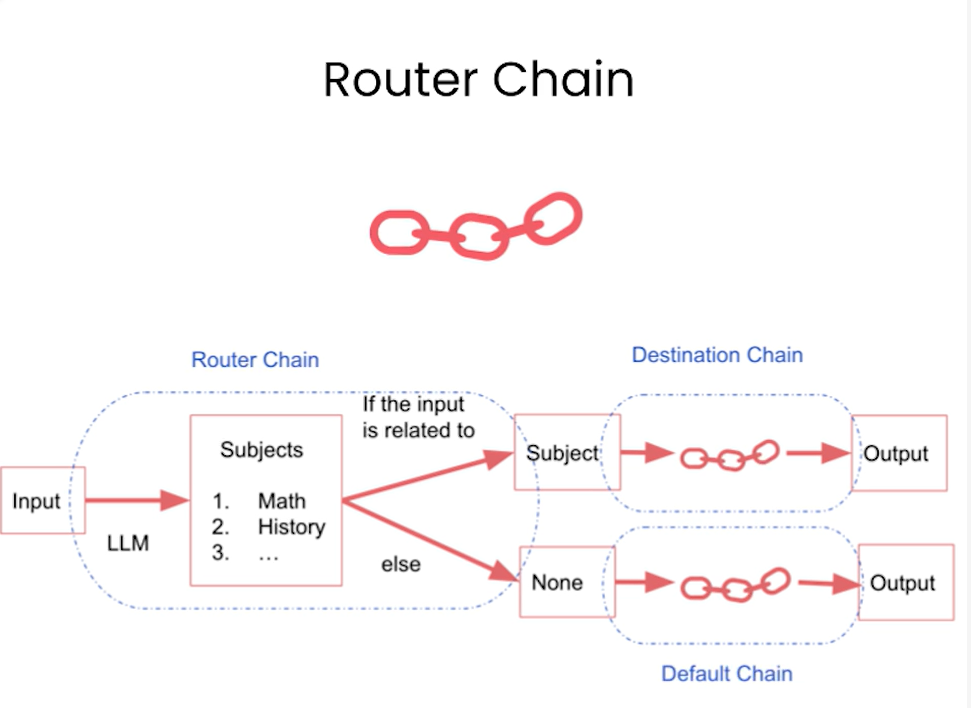


In [27]:
# Different prompt templates 

physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [28]:
# Assign names and descriptions to prompts 
# Pass this info to router chain to decide which subchain to pass inputs to

prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [29]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

# MultiPromptChain - a type of chain to use when routing between different prompt templates
# LLMRouterChain - use a LLM to route b/w different subchains
# RouterOutputParser - parses LLM output into a dictionary to be used for determining which chain to use 
                     # and what the input to that chain should be

In [30]:
llm = ChatOpenAI(temperature=0)

In [31]:
# Define destination chains - chains that will be called by the router chain
# Each destination chain is a LLM chain

destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [32]:
# Define default chain - the chain that is called when the router can't decide which of the subchains to use
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [44]:
# Define the template to instruct the LLM to route b/w different chains
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model, select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (must include the ```json)>>"""

In [45]:
# Create full router template by formatting with the prompt info defined above (flexible for different types)
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str)

# Create prompt_template from the full router template
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

# Create router chain by passing it to the LLM
router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [46]:
# Create the overall chain - containin router chain, destination chains and default chain
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [47]:
chain.run("What is black body radiation?")



> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.


'Black body radiation refers to the electromagnetic radiation emitted by an object that absorbs all incident radiation and reflects or transmits none. It is called "black body" because it absorbs all wavelengths of light, appearing black at room temperature. \n\nAccording to Planck\'s law, black body radiation is characterized by a continuous spectrum of wavelengths and intensities, which depend on the temperature of the object. As the temperature increases, the peak intensity of the radiation shifts to shorter wavelengths, resulting in a change in color from red to orange, yellow, white, and eventually blue at very high temperatures.\n\nBlack body radiation is a fundamental concept in physics and has significant applications in various fields, including astrophysics, thermodynamics, and quantum mechanics. It played a crucial role in the development of quantum theory and understanding the behavior of light and matter.'

In [48]:
chain.run("what is 2 + 2")



> Entering new MultiPromptChain chain...
math: {'input': 'what is 2 + 2'}
> Finished chain.


'Thank you for your kind words! As a mathematician, I am happy to help with any math questions, no matter how simple or complex they may be.\n\nThe question you\'ve asked is a basic addition problem: "What is 2 + 2?" To solve this, we can simply add the two numbers together:\n\n2 + 2 = 4\n\nTherefore, the answer to the question "What is 2 + 2?" is 4.'

In [50]:
chain.run("Why does every cell in our body contain DNA?")



> Entering new MultiPromptChain chain...
None: {'input': 'Why does every cell in our body contain DNA?'}
> Finished chain.


'Every cell in our body contains DNA because DNA is the genetic material that carries the instructions for the development, functioning, and reproduction of all living organisms. DNA contains the information necessary for the synthesis of proteins, which are essential for the structure and function of cells. It serves as a blueprint for the production of specific proteins that determine the characteristics and traits of an organism. Additionally, DNA is responsible for the transmission of genetic information from one generation to the next, ensuring the continuity of life. Therefore, every cell in our body contains DNA to ensure proper cellular function and to pass on genetic information to future generations.'